## Introduction

This notebook is the result of a short investigation of the 2015 Pronto Data Challenge.
It is intended to be a demonstration of how IPython/Jupyter notebooks
can be easily combined with the pandas, spark and d3 libraries based on previously existing demonstrations.

This notebook contains queries to generate two charts.
One explores trip flows between different regions of the Pronto system.
The second recreates a chart for a performance metric that has been measured in other bike share systems in the US.

Hopefully this notebook can be used to gain some quick insights into Pronto's first year, but it it is intended more to be a starting point for more queries.

## Library Initialization

To begin with, the system needs to be initialized and the libraries loaded.  This notebook relies on a combination of Pandas dataframes and Spark SQL queries to generate data for the D3 javascript and Matplotlib libraries.  It is based on examples that are referenced in the code comments.

This section can be skipped if you are more interested in the results than the underlying technology.

In [1]:
# see http://stackoverflow.com/questions/29783520/create-pyspark-profile-for-ipython
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="ProntoChallenge")

In [2]:
# see http://spark.apache.org/docs/latest/sql-programming-guide.html#starting-point-sqlcontext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
import pandas as pd
import numpy as np

Load the data.  Pandas currently is currently more convenient than Spark at reading csv files of the format provided by Pronto, so we'll read them as Pandas dataframes.

In [4]:
station_df = pd.read_csv('2015_station_data.csv')
trip_df = pd.read_csv('2015_trip_data.csv')
trip_df.dropna()
weather_df = pd.read_csv('2015_weather_data.csv')
# it's bigger dataset, and not used in this example.
#status_df = pd.read_csv('2015_status_data.csv')

## Visualization of Inter- and Intra-region Trips

This notebook does not do automated clustering on the data.  But as a quick alternative, it turns out the station ids have a region label in them.  The following lines make that an explicit column in the station table.

In [5]:
trip_df.loc[:,'from_region'] = trip_df.loc[:,'from_station_id'].map(lambda r: str(r).split('-')[0])
trip_df.loc[:,'to_region'] = trip_df.loc[:,'to_station_id'].map(lambda r: str(r).split('-')[0])
station_df.loc[:,'region'] = station_df.loc[:,'terminal'].map(lambda r: str(r).split('-')[0])

The Pandas library can be used alone, but in some situations the SQL language is more useful.  The Spark library converts easily between Pandas and Spark SQL Dataframes.  The following are SQL versions of the tables.

In [6]:
stations_sdf = sqlContext.createDataFrame(station_df)
stations_sdf.registerTempTable('stations')

In [7]:
trip_sdf = sqlContext.createDataFrame(trip_df)
trip_sdf.registerTempTable('trips')

The SQL tables can now be used to group and count the trips by region labels.  Pandas could be used to express this query as well, though the specific query would be different.

In [8]:
regions_sql = """
    SELECT from_region, to_region, count(*) as trips
    FROM trips
    GROUP BY from_region, to_region
"""
region_result = sqlContext.sql(regions_sql)

One benefit of Pandas dataframes is they display automatically as a table in Jupyter notebooks.
This is just the first five lines of the region result.

In [9]:
region_result.toPandas()[:5]

,from_region,to_region,trips
0,DPD,WF,35
1,CH,UW,388
2,UW,UW,2828
3,CH,DPD,411
4,UW,DPD,212


This table is easier to interpret as a cross-tabulation.
The cross-tabulation will also make it easier to display as a chart later.

In [10]:
region_to_from_df = region_result.toPandas()
region_crosstab_df = pd.crosstab(trip_df.from_region, trip_df.to_region)
region_crosstab_df

to_region,BT,CBD,CD,CH,DPD,EL,FH,ID,PS,Pronto shop,SLU,UD,UW,WF
from_region,,,,,,,,,,,,,,
BT,2200,3587,5,728,842,627,49,180,982,0,4809,111,50,1503
CBD,2974,3195,27,1341,184,305,159,608,2174,2,4175,75,31,1544
CD,8,73,13,116,2,1,36,57,82,0,17,3,0,32
CH,2150,6493,236,11698,411,1133,1284,677,1502,4,8105,594,388,355
DPD,524,165,3,112,316,282,12,4,79,0,1212,412,235,35
EL,559,244,1,199,284,1515,22,7,82,0,2473,601,472,71
FH,177,708,48,1345,30,101,231,225,389,0,568,18,10,38
ID,100,482,18,214,6,5,80,137,140,0,132,4,3,143
PS,475,1372,21,288,64,53,99,156,465,0,764,5,0,960


For use with the javascript D3 visualization library, one last format conversion to JSON is helpful.  

In [11]:
import json

# see http://stackoverflow.com/questions/3488934/simplejson-and-numpy-array
class NumpyAwareJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray) and obj.ndim == 1:
            return obj.tolist()

region_json = json.dumps(region_crosstab_df.as_matrix().tolist(), cls=NumpyAwareJSONEncoder)
region_labels = list(region_crosstab_df.columns.values)

The following section is based on a demonstration by Ariel Keselman on integrating the D3 javascript library with IPython/Jupyter notebooks, specifically with chord charts.

Note that in the current version of this notebook, the json matrix and region labels have been copied to the javascript template by hand.

In [12]:
# This section is modified from https://github.com/skariel/IPython_d3_js_demo/blob/master/d3_js_demo.ipynb
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    fn = '__tmp22236_1.html'
    return IFrame('files/'+fn,w,h)

def chord_chart(w=800,
                h=800,
                ball_count=150,
                rad_min=2,
                rad_fac=11,
                color_count=14):
    d={
       'width'      :w,
       'height'     :h,
       'ball_count' :ball_count,
       'rad_min'    :rad_min,
       'rad_fac'    :rad_fac,
       'color_count':color_count
       }
    with open('chord.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

## Note: unfortunately the chart will not render in a static notebook, such as on github.

The arcs around the perimeter represent the region labels for the stations, and their size represents the number of trips.  The paths between regions represent all the intra-region trips.  The width of the path where it touches a region arc is the number of trips originating in that region.  If you hover over a region trips in other regions will be dimmed.

At first glance this chart has a few noticable features.  The large number of intra-region trips stands out, though several smaller regions are exceptions (First Hill, Belltown and Central Business District.  Some regions, such as UW and UD are tightly connected only to each other.  Capitol Hill does originate more trips to South Lake Union, the Central Business District and Belltown than return, but the effect doesn't dominate the chart.  Pioneer Square has very even connections to other regions, which may be a function of the Second Avenue protected bike lane.

In [13]:
chord_chart(ball_count=30, color_count=14, rad_fac=10, rad_min=3, w=800, h=800)

The thing to remember is the size of the regions in the chart above is based on the number of trips.  Another query can show how many stations are in each region.  This query also assigns random colors (different from the chart above) for use later.

In [14]:
stations_per_region_sql = """
    SELECT region, count(*) as n_stations
    FROM stations
    GROUP BY region
"""
stations_per_region = sqlContext.sql(stations_per_region_sql).toPandas()

import random
random.seed(20151115)
stations_per_region.loc[:,'color'] = stations_per_region.iloc[:,0].map(
    lambda n: '#%02X%02X%02X' % (random.randint(0,255),
                                 random.randint(0,255),
                                 random.randint(0,255)))
stations_per_region

,region,n_stations,color
0,UD,4,#C9BE53
1,UW,6,#7557AA
2,DPD,2,#D84B0A
3,BT,4,#A8C00D
4,ID,1,#3A949E
5,CBD,6,#E861ED
6,CD,1,#CB3C65
7,CH,10,#D64025
8,PS,2,#C1F771
9,WF,2,#7F7B14


This shows that South Lake Union is a group of only ten stations.  It's the same for Capitol Hill.  UW and the University District combined are also 10 stations.  Pioneer square has only two stations, but they seem to be serving a distinct purpose, as are the four BT stations and the two waterfront stations.

My immediate concern is whether we currently have three network fragments (UW/UD, Capitol Hill and SLU/CBD/BT) rather than one dense network.  The data does have enough information to check how our network is performing compared to some existing networks in the US. This will be the topic of the next chart.

## 15 Minute Destinations

Analysis of other bike share networks shows that usage statistics rise non-linearly with station density.  http://nacto.org/wp-content/uploads/2015/09/NACTO_Walkable-Station-Spacing-Is-Key-For-Bike-Share_Sc.pdf

The following query simply counts station pairs
that have had a trip of less than 15 minutes.
They are then grouped and sorted from most destinations to least. 

In [15]:
stations_within_15_min_sql = """
    SELECT DISTINCT from_station_id as station_id,
                    from_station_name as station_name,
                    count(DISTINCT to_station_id) as destinations
    FROM trips
    WHERE tripduration <= (15*60)
    AND from_station_id != to_station_id
    GROUP BY from_station_id, from_station_name
    ORDER BY destinations DESC
"""
n_destinations_df = sqlContext.sql(stations_within_15_min_sql).toPandas()
n_destinations_df

,station_id,station_name,destinations
0,CH-05,15th Ave E & E Thomas St,44
1,CH-02,E Harrison St & Broadway Ave E,43
2,CH-03,Summit Ave E & E Republican St,43
3,CH-01,Summit Ave & E Denny Way,42
4,SLU-01,REI / Yale Ave N & John St,42
5,CH-08,Cal Anderson Park / 11th Ave & Pine St,42
6,CH-15,12th Ave & E Mercer St,42
7,CH-12,Bellevue Ave & E Pine St,41
8,CH-07,E Pine St & 16th Ave,41
9,SLU-16,Pine St & 9th Ave,40


This shows that there are 10 stations that are reasonably well connected (40+ destinations).  The two busy waterfront stations actually only have a mediocre number of destinations (19 and 23).  The University stations have very low connectivity and Children's Hospital is an outlier at the edge of the network.

The graphs in the NACTO paper suggest that stations with 40 destinations could expect to have around 10-30 departures per day.  This can also be checked.

In [17]:
departures_per_day_sql = """
    SELECT from_station_id as station_id, count(*)/365 as departures
    FROM trips
    GROUP BY from_station_id
    ORDER BY departures DESC
"""
arrivals_per_day_sql = """
    SELECT to_station_id as station_id, count(*)/365 as arrivals
    FROM trips
    GROUP BY to_station_id
    ORDER BY arrivals DESC
"""
departures_df = sqlContext.sql(departures_per_day_sql).toPandas()
arrivals_df = sqlContext.sql(arrivals_per_day_sql).toPandas()
n_trips_df = arrivals_df.merge(departures_df).merge(n_destinations_df)
n_trips_df.loc[:,'trips_to_from'] = n_trips_df.loc[:,'arrivals'] + n_trips_df.loc[:,'departures']

# merge in region, stations_per_region and region color
n_trips_df.loc[:,'region'] = n_trips_df.loc[:,'station_id'].map(lambda r: str(r).split('-')[0])
n_trips_df = n_trips_df.merge(stations_per_region.loc[:,['region','color']], on='region')

n_trips_df

,station_id,arrivals,departures,station_name,destinations,trips_to_from,region,color
0,WF-01,19.758904,18.471233,Pier 69 / Alaskan Way & Clay St,23,38.230137,WF,#7F7B14
1,WF-04,12.106849,8.660274,Seattle Aquarium / Alaskan Way S & Elliott Bay...,19,20.767123,WF,#7F7B14
2,CBD-13,19.695890,14.753425,2nd Ave & Pine St,39,34.449315,CBD,#E861ED
3,CBD-06,12.512329,8.246575,2nd Ave & Spring St,37,20.758904,CBD,#E861ED
4,CBD-05,11.241096,7.936986,1st Ave & Marion St,29,19.178082,CBD,#E861ED
5,CBD-03,10.846575,8.147945,7th Ave & Union St,40,18.994521,CBD,#E861ED
6,CBD-07,5.295890,5.035616,City Hall / 4th Ave & James St,33,10.331507,CBD,#E861ED
7,CBD-04,1.791781,1.890411,Union St & 4th Ave,35,3.682192,CBD,#E861ED
8,BT-01,15.890411,16.123288,3rd Ave & Broad St,31,32.013699,BT,#A8C00D
9,BT-05,9.476712,9.227397,2nd Ave & Blanchard St,36,18.704110,BT,#A8C00D


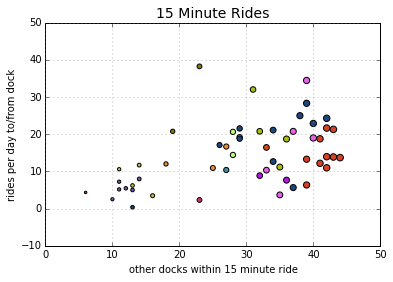

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

_, rides = plt.subplots()
rides.grid(color='grey',
           linestyle='dotted')

scatter = rides.scatter(n_trips_df.loc[:,'destinations'],
                        n_trips_df.loc[:,'trips_to_from'],
                        c=n_trips_df.loc[:,'color'],
                        s = n_trips_df.loc[:,'destinations'])

rides.set_xlabel('other docks within 15 minute ride')
rides.set_ylabel('rides per day to/from dock')
rides.set_title("15 Minute Rides", size=14);

This plot looks similar to the plots in the NACTO paper.  The stations with the most destinations have between 10 and 30 rides per day.  The more remote stations appear to have fewer rides.  Because this notebook did not correct for stations that were added during the year, a few stations such as the new station at 9th and Mercer do not have an accurate rides per day number. 

Note also that the region colors in this plot do not correspond to the colors in the chord chart above, and there is no color/region key.  Still it is possible to see that the different regions have slightly different usage characteristics beyond station density and region size.

## Conclusions and Next Steps

This notebook is intended to provides some quick insight into Pronto performance after a year of operation and toin demonstrate some useful technologies for continuing investigation.

The inter-region trip chart seems to show that there is some fragmentation and hill effects in the network, but they are not out of scale when compared to intra-region trips in the larger regions and the well-connected central business district, Belltown and even pioneer square regions.

The 15 minute rides chart shows that our network has similar performance to other bike share systems, but with the caveat that less dense and peripheral stations do not have enough destinations see high usage.

The Pandas, Spark and D3 libraries make it easy to manipulate and visualize this data.  Similar charts can be generated by demographics, time of day or year with slight modifications to the query.  It would be interesting to see the charts with automated region clusters rather than the region labels from the station table.
